# Exploratory Data analysis of Trip Chains

After assigning an activity chain to each individual, we need to map these activities to geographic locations. We start with primary locations (work, school) and fill in the gaps later with discretionary locations. This notebook is a visual inspection of the activity_chains data - it is a precursor to the actual assignment of locations which is done in `3_locations_primary.ipynb`.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Explore trip from and trip to for all individual activities

In [16]:
# read parquet file
activity_chains = pd.read_parquet('../data/interim/matching/spc_with_nts_trips.parquet')
activity_chains.head(10)

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,...,TripStart,TripEnd,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,TripOrigGOR_B02ID,TripDestGOR_B02ID,W5,W5xHH
0,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,330.0,345.0,10.0,10.0,15.0,15.0,8.0,8.0,0.680422,1.000000
1,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,885.0,900.0,10.0,10.0,15.0,15.0,8.0,8.0,0.680422,1.000000
2,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,330.0,345.0,10.0,10.0,15.0,15.0,8.0,8.0,0.727735,1.069535
3,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,795.0,810.0,10.0,10.0,15.0,15.0,8.0,8.0,0.727735,1.069535
4,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,480.0,540.0,10.0,10.0,60.0,60.0,8.0,8.0,0.758707,1.115053
5,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,540.0,600.0,10.0,10.0,60.0,60.0,8.0,8.0,0.758707,1.115053
6,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,720.0,750.0,1.5,1.5,30.0,30.0,8.0,8.0,0.758707,1.115053
7,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,750.0,780.0,1.5,1.5,30.0,30.0,8.0,8.0,0.758707,1.115053
8,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,900.0,910.0,4.0,4.0,10.0,10.0,8.0,8.0,0.765863,1.125570
9,1193050,479338,"{'x': -1.3864760398864746, 'y': 53.94084167480...",2910658,E02002330,E00059012,"[1193050, 1193051]",Q,86.0,1,...,960.0,970.0,4.0,4.0,10.0,10.0,8.0,8.0,0.765863,1.125570


### Data preparation: Mapping trip purposes

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [17]:
activity_chains = activity_chains.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

Check the NTS glossary [here](https://www.gov.uk/government/statistics/national-travel-survey-2022-technical-report/national-travel-survey-2022-technical-report-glossary) to understand what the trip purposes mean.

add an escort column

In [18]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "motorcycle",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "taxi",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop_food",  #'Food shopping',
    5: "shop_other",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other_eat_drink",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other_eat_drink",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other_social",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other_sport",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort_home",  #'Escort home',
    18: "escort_work",  #'Escort work',
    19: "escort_work",  #'Escort in course of work',
    20: "escort_education",  #'Escort education',
    21: "escort_shopping",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


activity_chains["mode"] = activity_chains["mode"].map(mode_mapping)

activity_chains["oact"] = activity_chains["oact"].map(purp_mapping)

activity_chains["dact"] = activity_chains["dact"].map(purp_mapping)

### Exploratory Data Analysis: Show the distribution of trip purposes

Plot some heatmaps to show the composition of purposes across the dataset (e.g. home->work, home-> school, work->visit, etc.)

#### Heatmap 1: Overall number of trips

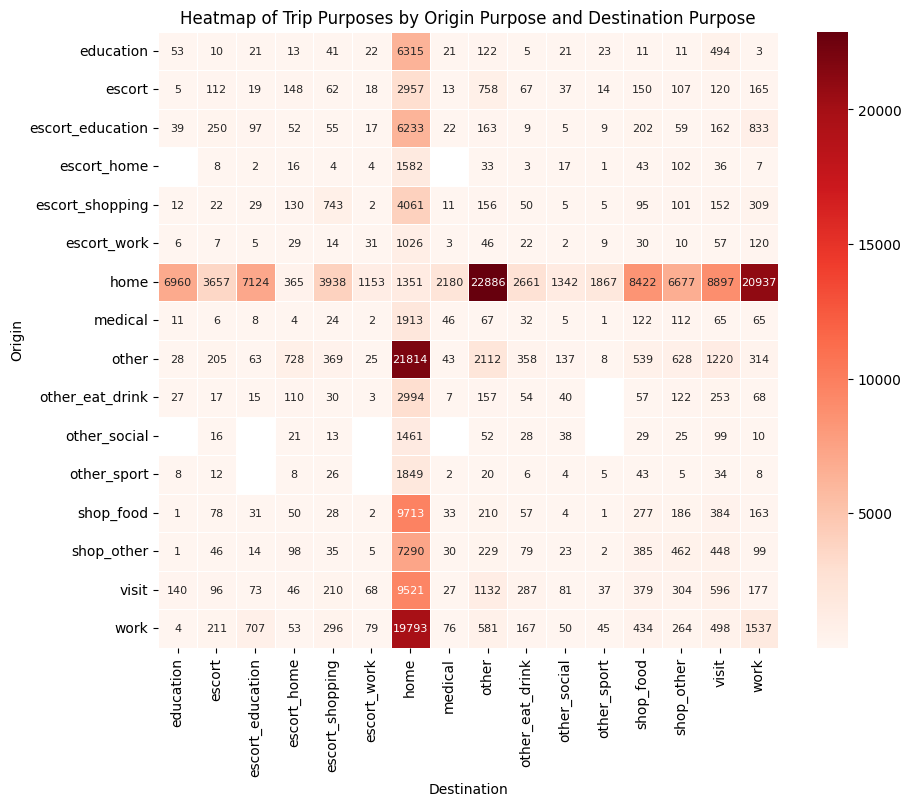

In [19]:
# heatmap showing oact and dact


# create a pivot table
activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count')

# Set the size of the figure
plt.figure(figsize=(10, 8))
# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".0f", cmap='Reds', linewidth=.5, annot_kws={"size": 8})

plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()


#### Heatmap 2: % of Total Trips

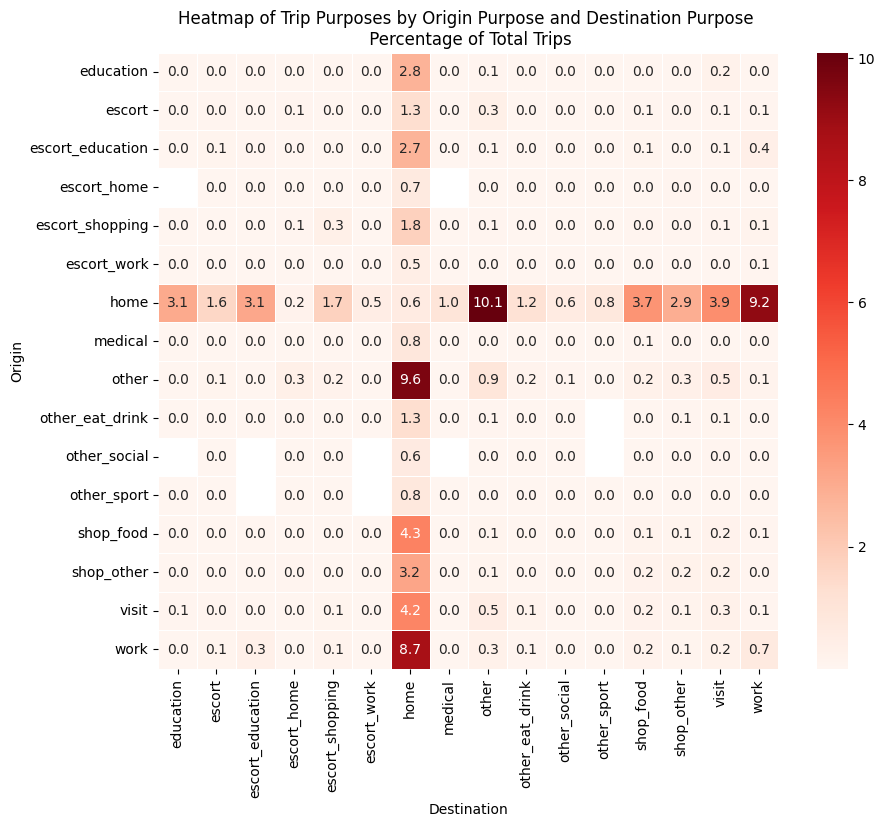

In [20]:
# Set the size of the figure
plt.figure(figsize=(10, 8))

activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count', margins=True, margins_name='Total')
activity_chains_pivot = activity_chains_pivot.div(activity_chains_pivot.loc['Total', 'Total']) * 100
# drop Total row and column
activity_chains_pivot = activity_chains_pivot.drop('Total', axis=0)
activity_chains_pivot = activity_chains_pivot.drop('Total', axis=1)

# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".1f", cmap='Reds', linewidth=.5)

plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose \n Percentage of Total Trips')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()

#### Heatmap 3: Column Normalized (i.e. % of total trips per destination purpose)

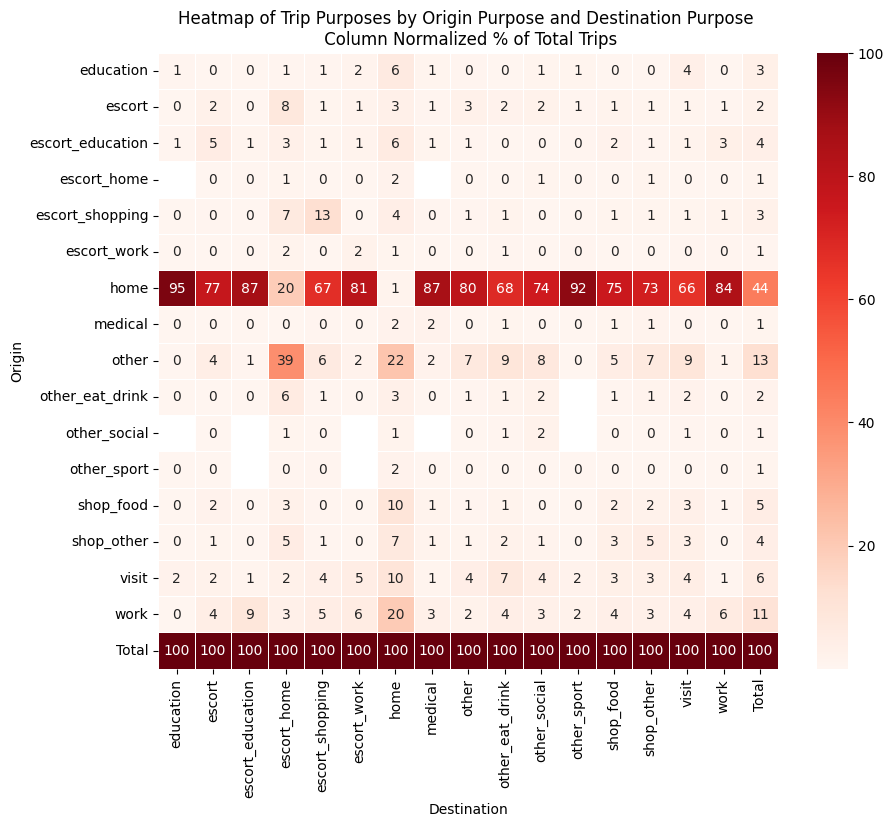

In [21]:
plt.figure(figsize=(10, 8))

activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count', margins=True, margins_name='Total')
activity_chains_pivot = activity_chains_pivot.div(activity_chains_pivot.loc['Total'], axis=1)*100

# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".0f", cmap='Reds', linewidth=.5)


plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose \n Column Normalized % of Total Trips')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()


#### Heatmap 4: Row Normalized (i.e. % of total trips per origin purpose)

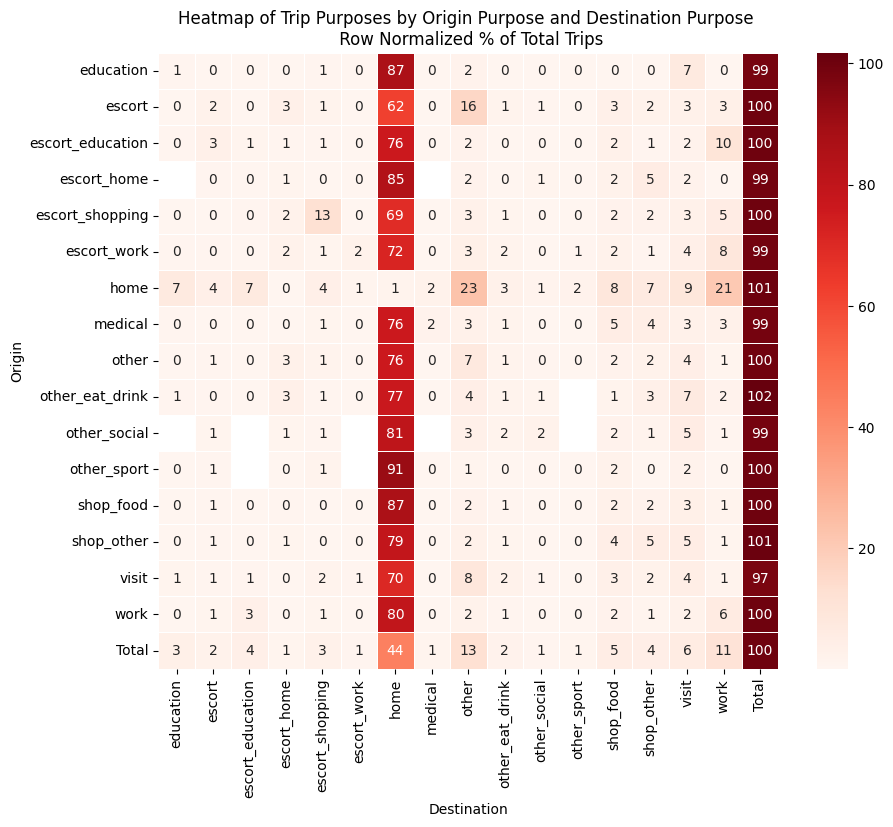

In [22]:
plt.figure(figsize=(10, 8))

# same plot but I want the values to be the percentage of the total trips
activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count', margins=True, margins_name='Total')
activity_chains_pivot = activity_chains_pivot.div(activity_chains_pivot.loc['Total'], axis=0)*100

# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".0f", cmap='Reds', linewidth=.5)

plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose \n Row Normalized % of Total Trips')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()


## Explorative Data Analysis: Show the distribution of trip length by purpose

All trips with purpose = Education

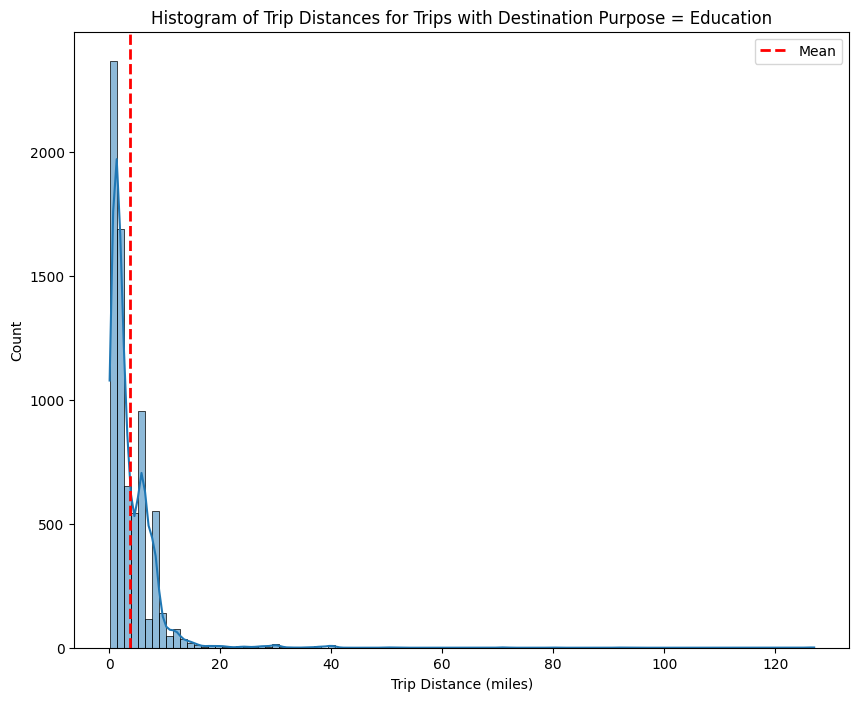

In [23]:

plt.figure(figsize=(10, 8))
sns.histplot(data=activity_chains[activity_chains['dact'] == 'education'], x='TripDisIncSW', bins=100, kde=True)
plt.title('Histogram of Trip Distances for Trips with Destination Purpose = Education')
# add labeled mean line
plt.axvline(activity_chains[activity_chains['dact'] == 'education']['TripDisIncSW'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.legend()
plt.show()

Disaggregated by age group

In [24]:
# add NTS values corresponding to age group codes

dict_nts_ind_age = {-10: 'DEAD',
                    -8: 'NA',
                    1: '0-4',
                    2: '5-10',
                    3: '11-16',
                    4: '17-20',
                    5: '21-29',
                    6: '30-39',
                    7: '40-49',
                    8: '50-59',
                    9: '60+'
                    }

activity_chains['age_group_years'] = activity_chains['age_group'].map(dict_nts_ind_age)


Text(0.5, 0.98, 'Histogram of Trip Distances for Trips with Destination Purpose = Education')

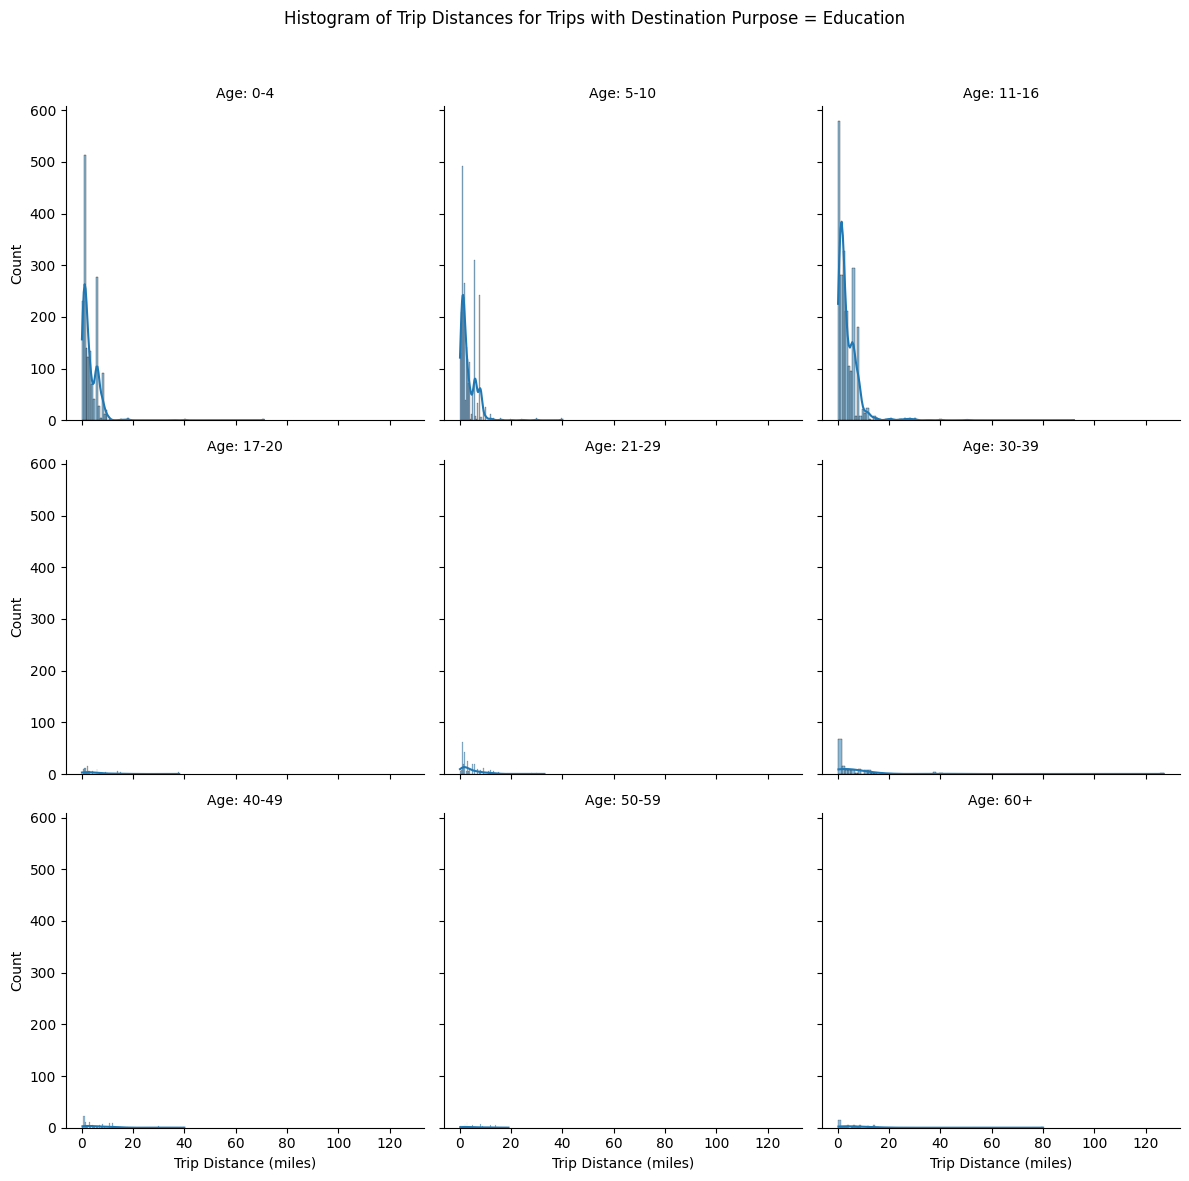

In [25]:
# histogram of trip distances for trips with destination purpose = education. Faceted by age_group column
age_group_order = activity_chains['age_group'].sort_values().unique()

# Convert the 'age_group' order to corresponding 'age_group_years' order
age_group_years_order = [activity_chains.loc[activity_chains['age_group'] == age_group, 'age_group_years'].iloc[0] for age_group in age_group_order]

# Create the FacetGrid with the 'col_order' parameter
g = sns.FacetGrid(activity_chains[activity_chains['dact'] == 'education'], col='age_group_years', col_wrap=3, height=4, col_order=age_group_years_order)
g.map(sns.histplot, 'TripDisIncSW', bins=100, kde=True)

# Set the titles
g.set_titles('Age: {col_name}')
# add x and y axis labels
g.set_axis_labels('Trip Distance (miles)', 'Count')
# Add main title
plt.subplots_adjust(top=0.9)
g.figure.suptitle('Histogram of Trip Distances for Trips with Destination Purpose = Education')

Text(0.5, 0.98, 'Histogram of Trip Distances for Trips with Destination Purpose = Education')

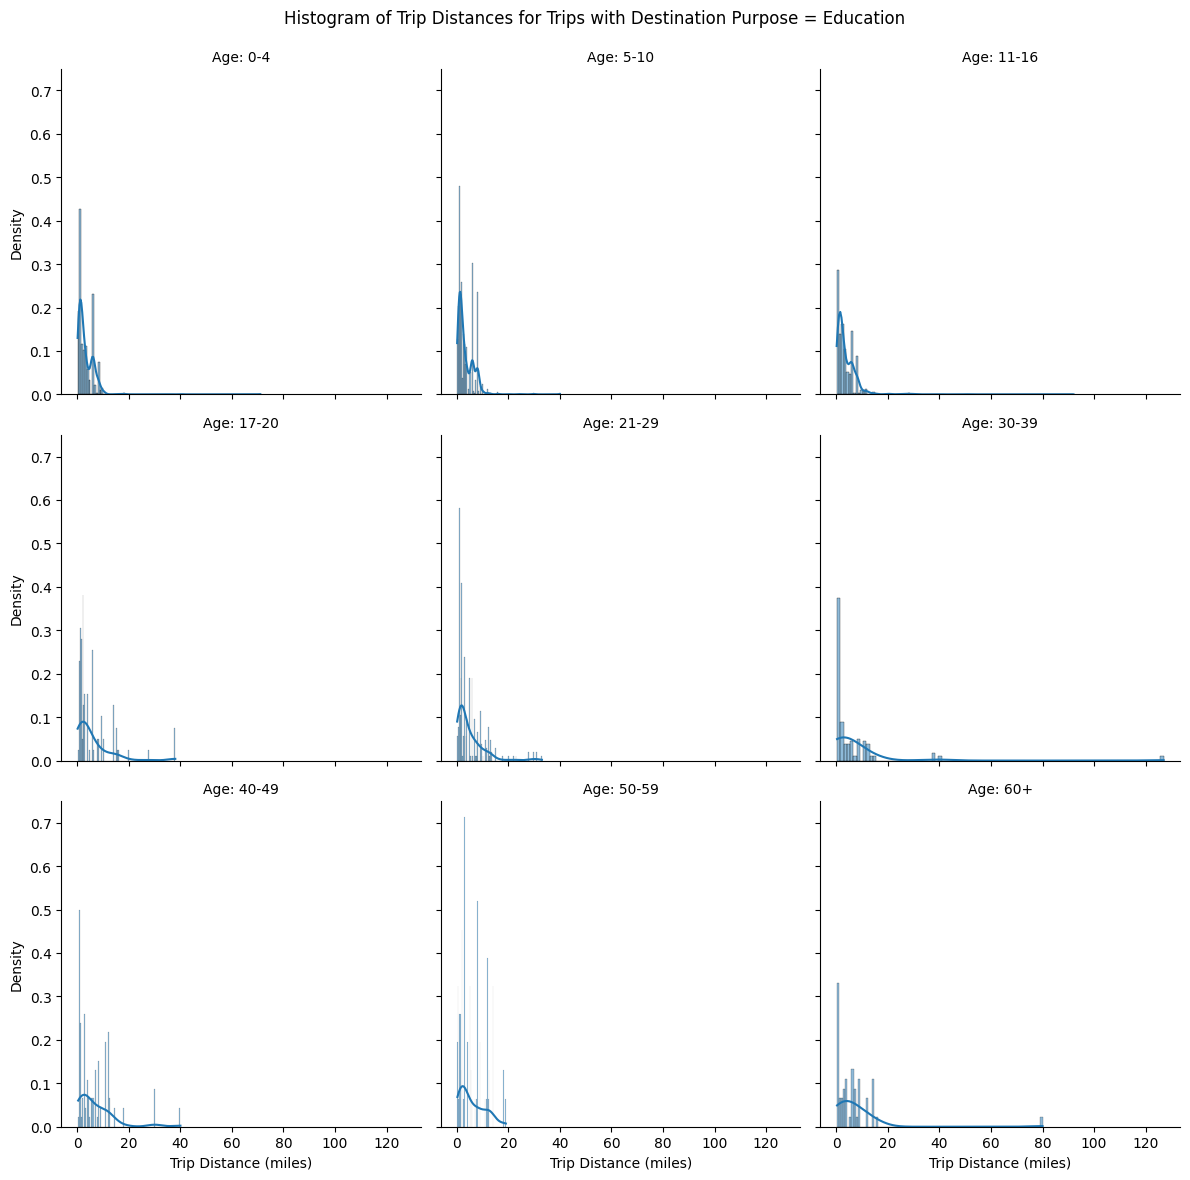

In [26]:
# same plot as above, but normalize the totals per group
g = sns.FacetGrid(activity_chains[activity_chains['dact'] == 'education'], col='age_group_years', col_wrap=3, height=4, col_order=age_group_years_order)
g.map(sns.histplot, 'TripDisIncSW', bins=100, kde=True, stat='density')

# Set the titles
g.set_titles('Age: {col_name}')
# add x and y axis labels
g.set_axis_labels('Trip Distance (miles)', 'Density')
# Add main title
plt.subplots_adjust(top=0.93)
g.figure.suptitle('Histogram of Trip Distances for Trips with Destination Purpose = Education')

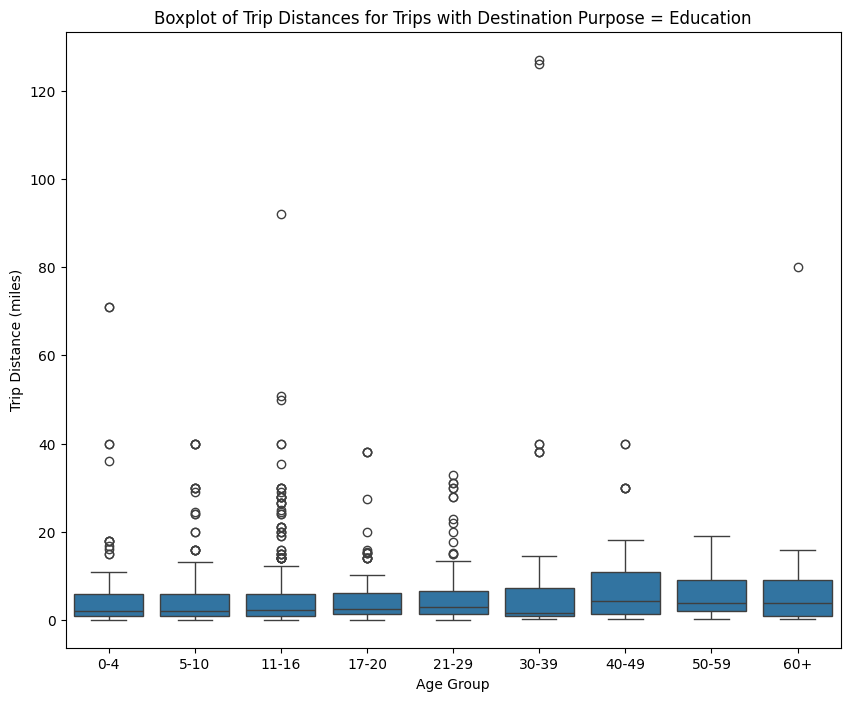

In [27]:
# boxplot instead of histogram
plt.figure(figsize=(10, 8))
sns.boxplot(data=activity_chains[activity_chains['dact'] == 'education'], x='age_group_years', y='TripDisIncSW', order=age_group_years_order)
plt.title('Boxplot of Trip Distances for Trips with Destination Purpose = Education')
plt.xlabel('Age Group')
plt.ylabel('Trip Distance (miles)')
plt.show()


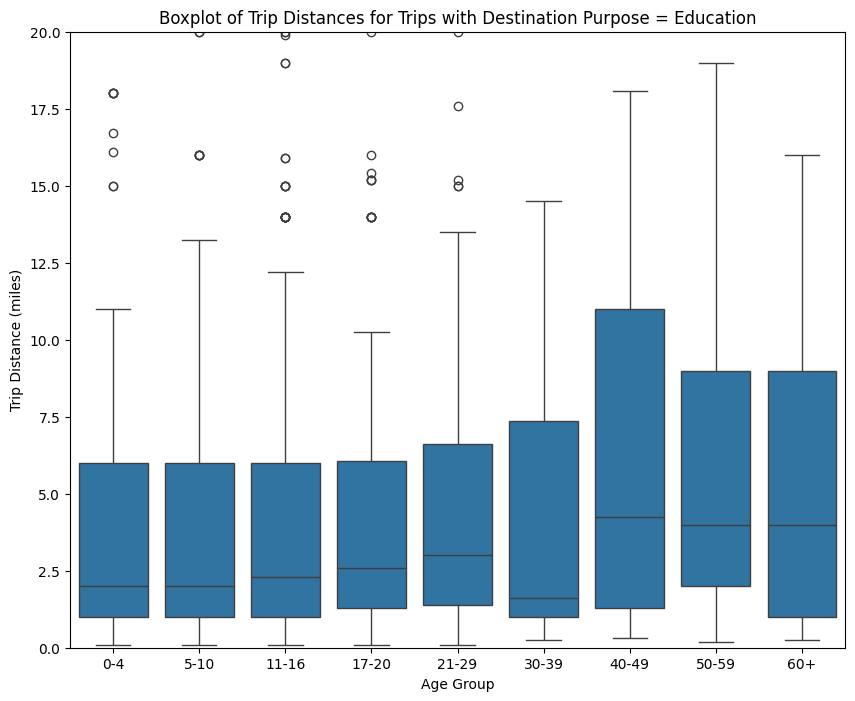

In [28]:
# trim y axis to remove outliers
plt.figure(figsize=(10, 8))
sns.boxplot(data=activity_chains[activity_chains['dact'] == 'education'], x='age_group_years', y='TripDisIncSW', order=age_group_years_order)
plt.ylim(0, 20)
plt.title('Boxplot of Trip Distances for Trips with Destination Purpose = Education')
plt.xlabel('Age Group')
plt.ylabel('Trip Distance (miles)')
plt.show()